Data from many different sources

# Introduction

In [46]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import vice


In [47]:
from surp import ViceModel, yields, subgiants, DATA_DIR
from surp import gce_math as gcem

import surp
import arya
from arya import COLORS

In [48]:
from singlezone import run_singlezone, exp_sfh

In [49]:
def to_nice(apogee_name):
    return "[" + apogee_name.title().replace("_", "/") + "]"

In [50]:
def plot_abund_errs(df, x="O_H", y="C_O", **kwargs):
    xs = df[x].values
    ys =  df[y].values
    xerr = df[f"{x}_err"].values
    yerr = df[f"{y}_err"].values
    filt = ~np.isnan(xerr) 
    filt &= ~np.isnan(yerr)
    filt &= xerr > 0
    filt &= yerr > 0
    
    plt.errorbar(xs[filt], ys[filt], xerr=xerr[filt], yerr=yerr[filt], fmt="o", capsize=0, **kwargs)
    plt.xlabel(to_nice(x))
    plt.ylabel(to_nice(y))

In [51]:
def plot_sample(df, **kwargs):    
    plot_abund_errs(df, x="FE_H", y="O_FE", **kwargs)
    plt.show()
    
    plot_abund_errs(df, **kwargs)
    plt.show()
    
    plot_abund_errs(df, x="O_FE", **kwargs)
    plt.show()
    
    if "MG_FE" in df.columns:
        plot_abund_errs(df, x="O_H", y="O_MG", **kwargs)
        plot_abund_errs(df, x="MG_H", y="C_MG", **kwargs)
        plot_abund_errs(df, x="MG_FE", y="C_MG", **kwargs)
        plt.show()
                    

In [52]:
def calc_errs(df, idx=None):
    series = pd.Series()
    series["O_H_err"] = np.nanmean(df["O_H_err"])
    series["C_O_err"] = np.nanmean(df["C_O_err"])
    
    if idx is None:
        O_H = np.mean(df.O_H)
        C_O = np.mean(df.C_O)
        
        idx = np.argmin((df.O_H - O_H)**2 )#+ (df.C_O - C_O)**2)
        series["O_H"] = df.O_H.iloc[idx]
        series["C_O"] = df.C_O.iloc[idx]
    
    return series.to_frame().T

In [53]:
def plot_sample_err(df, df_err=None, color=COLORS[0], marker="*", label="", **kwargs):
    if df_err is None:
        df_err = calc_errs(df)
        
    plt.scatter(df["O_H"], df["C_O"], marker=marker, color=color, label=label, **kwargs)
    

    plt.errorbar(df_err["O_H"], df_err["C_O"],  xerr=df_err.O_H_err, yerr=df_err.C_O_err,
             marker="none", ls="none", color=color, capsize=0, **kwargs)
    
    plt.xlabel("[O/H]")
    plt.ylabel("[C/O]")

In [54]:
surp.set_yields(verbose=False)

In [55]:
all_stars = pd.read_csv("data_analysis/amarsi19_cleaned.csv")

In [56]:
all_star_err = pd.DataFrame()


# split into two regemes and plot error bars
mh_cut = -0.3

low_z = all_stars[all_stars["O_H"] < mh_cut]
high_z = all_stars[all_stars["O_H"] >= mh_cut]
all_star_err = pd.concat([calc_errs(low_z), calc_errs(high_z)], ignore_index=True)
all_star_err

,O_H_err,C_O_err,O_H,C_O
0,0.023074,0.060948,-1.0091,-0.5907
1,0.018365,0.031701,0.0018,-0.0034


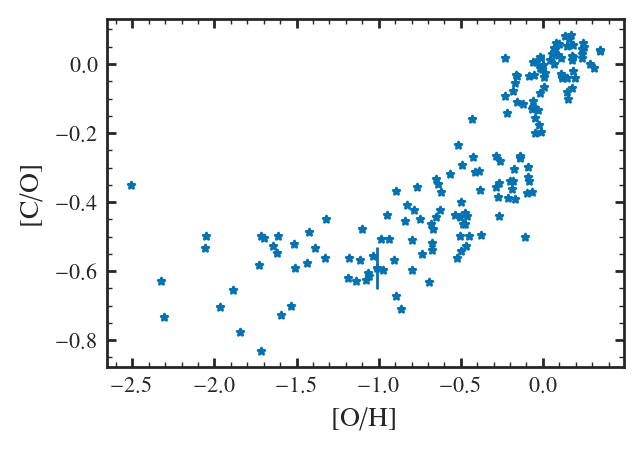

In [57]:
plot_sample_err(all_stars, all_star_err)

In [58]:
RL = pd.read_csv("data_analysis/RL_combined.csv")
RL_err = calc_errs(RL)

In [59]:
DLA = pd.read_csv("data_analysis/DLA_combined.csv")
DLA_err = calc_errs(DLA)

In [60]:
dwarfs = pd.read_csv("data_analysis/dwarfs_combined.csv")
dwarf_err = calc_errs(dwarfs)

In [61]:
high_z = pd.read_csv("data_analysis/high_z_cleaned.csv")
high_z_err = calc_errs(high_z)

# Fiducial model

In [62]:
subgiants_ha = subgiants[subgiants.high_alpha]

fiducial = ViceModel.from_file("../models/fiducial/run/model.json")

FileNotFoundError: [Errno 2] No such file or directory: '../models/fiducial/run/model.json'

In [64]:
def plot_fiducial():
    #surp.plots.plot_annulus_at_t(fiducial, "O_H", "C_O", label="Model (present day)", zorder=9, lw=1.5, color=arya.style.COLORS[0])
    pass
    
plot_fiducial()

Parameters from james et al. dwarf paper:

- $\tau_{\rm in} = 1.01 \pm 0.13\,$Gyr
- $\eta = 8.8 \pm 0.9$
- $\tau_{\star} = 16.1 \pm 1.3\,$Gyr
- $\tau_{\rm end} = 5.4\pm0.3\,$Gyr
- $y_{\rm Fe}^{\rm cc} = 7.8\pm0.4 \times 10^{-4}$
- $y_{\rm Fe}^{\rm Ia} = 1.2\pm0.1\times 10^{-3}$

As we assume different O yields, we adjust $\eta$ accordingly. Our total O yields are 0.712e-3, so
$$
\frac{\eta}{
\eta_{\rm J+22}
} = 
\frac{y_O}{y_{\rm O, J+22}} = \frac{0.712}{1}
$$
in agrement with the difference in alpha-abundance assumptions. 
$$
\eta = 6.2 \pm 0.7
$$

# Singlezone models

## TODO: pull these somehow from the singlezone notebook

In [65]:
yp = surp.YieldParams.from_file("../models/fiducial/yield_params.toml")
surp.set_yields(yp)

sz_fiducial = run_singlezone()[1]

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   3.69e-03 MH^2 + 1.96e-03 MH +  1.45 × cristallo11             0.00e+00                       
                    2.20e-03                                                                                     

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: n
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VI

change dwarf parameters to
match Wukong from James’ dwarf paper. 𝜂 = 47.99 ± 5, 𝑡end = 3.36 ± 0.5,
𝜏★ = 44.97 ± 7, 𝜏sfh = 3.08 ± 1

In [68]:
yp_lowz = surp.YieldParams.from_file("../models/fruity/cc_BiLogLin/yield_params.toml")

surp.set_yields(yp_lowz)

y_scale = 0.6# 0.712

sz_models = [
    run_singlezone()[1],
    run_singlezone(eta=y_scale * 9.56, t_end=10.73, tau_star=26.60, tau_sfh=2.18, sfh=exp_sfh(None), mode="ifr")[1], # GSE
    run_singlezone(eta=y_scale * 48, t_end=3.4, tau_star=45, tau_sfh=3.08, sfh=exp_sfh(None), mode="ifr")[1], # wukong
]

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.20e-03 + 1.96e-03 [M/H] or   1.45 × cristallo11             0.00e+00                       
                    8.67e-04, else                                                                               

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: n
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VI

In [69]:
from surp.yields import calc_y

In [70]:
MoverH = np.linspace(-5, 0.5)
Z = gcem.MH_to_Z(MoverH)

y_total = calc_y(Z)
y_agb = calc_y(Z, kind="agb")
y_cc = calc_y(Z, kind="cc")
y_ia = calc_y(Z, kind="ia")

yo = calc_y(ele="o")

In [71]:
def plot_sz(zorder=10):
    #singlezone
    for i in range(len(sz_models)):
        out = sz_models[i]
        if i == 0:
            label="singlezone"
        else:
            label=""
        plt.plot(out.O_H, out.C_O, label=label, color="k", 
                 lw=1, zorder=zorder, ls=[":", "--", "-."][i])

    plt.plot(sz_fiducial.O_H, sz_fiducial.C_O, label=label, color="k", 
             lw=1, zorder=zorder)
    
    plt.xlabel("[O/H]")
    plt.ylabel("[C/O]")

In [72]:
sz_models[1]

,time,mgas,mstar,sfr,ifr,ofr,eta_0,r_eff,z_in(c),z_in(n),...,O_H,C_MG,N_MG,O_MG,MG_H,C_FE,N_FE,O_FE,MG_FE,FE_H
0,0.00,1.0,0.000000e+00,3.759398e-11,1.000000,2.156391e-10,5.736,0.095771,0.0,0.0,...,-inf,NaN,NaN,NaN,-inf,NaN,NaN,NaN,NaN,-inf
1,0.01,10000000.0,3.399356e-04,3.759399e-04,0.995423,2.156391e-03,5.736,0.095771,0.0,0.0,...,-10.436896,-0.579706,-0.305588,0.00046,-10.437357,-0.130321,0.143796,0.449845,0.449385,-10.886741
2,0.02,19929270.0,3.399357e+03,7.492207e-04,0.990868,4.297530e-03,5.736,0.120187,0.0,0.0,...,-3.736372,-0.579706,-0.305589,0.00046,-3.736832,-0.130321,0.143796,0.449845,0.449385,-4.186217
3,0.03,29788380.0,9.991095e+03,1.119864e-03,0.986333,6.423540e-03,5.736,0.136515,0.0,0.0,...,-3.435196,-0.579706,-0.305588,0.00046,-3.435657,-0.130321,0.143796,0.449845,0.449384,-3.885041
4,0.04,39577800.0,1.966095e+04,1.487887e-03,0.981819,8.534522e-03,5.736,0.148749,0.0,0.0,...,-3.258956,-0.579706,-0.305589,0.00046,-3.259417,-0.130321,0.143796,0.449845,0.449385,-3.708801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,10.69,326097600.0,1.730708e+08,1.225931e-02,0.007419,7.031938e-02,5.736,0.533510,0.0,0.0,...,-0.578889,-0.184918,-0.255582,0.00046,-0.579349,-0.151544,-0.222208,0.033834,0.033374,-0.612723
1070,10.70,325411400.0,1.731280e+08,1.223351e-02,0.007385,7.017141e-02,5.736,0.533757,0.0,0.0,...,-0.578400,-0.184858,-0.255519,0.00046,-0.578860,-0.151656,-0.222317,0.033662,0.033202,-0.612062
1071,10.71,324726500.0,1.731850e+08,1.220776e-02,0.007352,7.002372e-02,5.736,0.534005,0.0,0.0,...,-0.577911,-0.184798,-0.255457,0.00046,-0.578371,-0.151768,-0.222427,0.033490,0.033030,-0.611401
1072,10.72,324042900.0,1.732419e+08,1.218206e-02,0.007318,6.987631e-02,5.736,0.534252,0.0,0.0,...,-0.577422,-0.184738,-0.255394,0.00046,-0.577883,-0.151880,-0.222536,0.033318,0.032858,-0.610740


Text(0, 0.5, 'sfr')

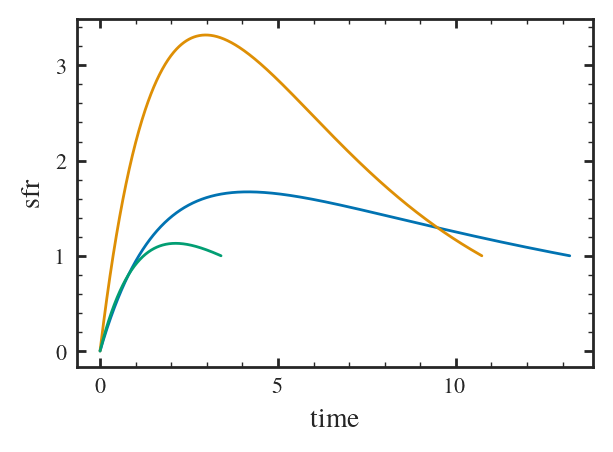

In [73]:
for model in sz_models:
    plt.plot(model.time, model.sfr / model.sfr.iloc[-1])
plt.xlabel("time")
plt.ylabel("sfr")

Text(0, 0.5, 'ifr')

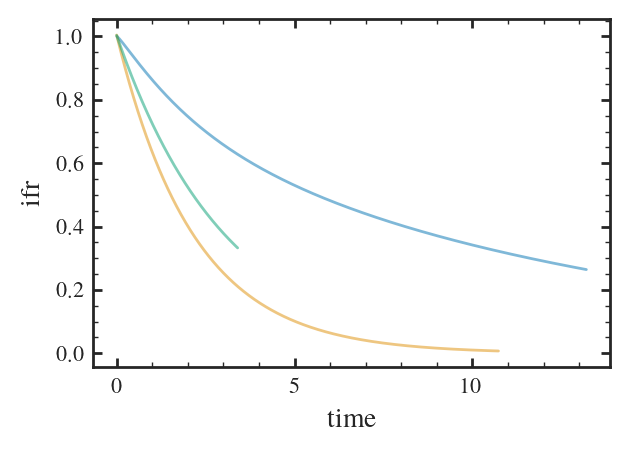

In [74]:
for model in sz_models:
    plt.plot(model.time, model.ifr / model.ifr.iloc[1], alpha=0.5)
plt.xlabel("time")
plt.ylabel("ifr")

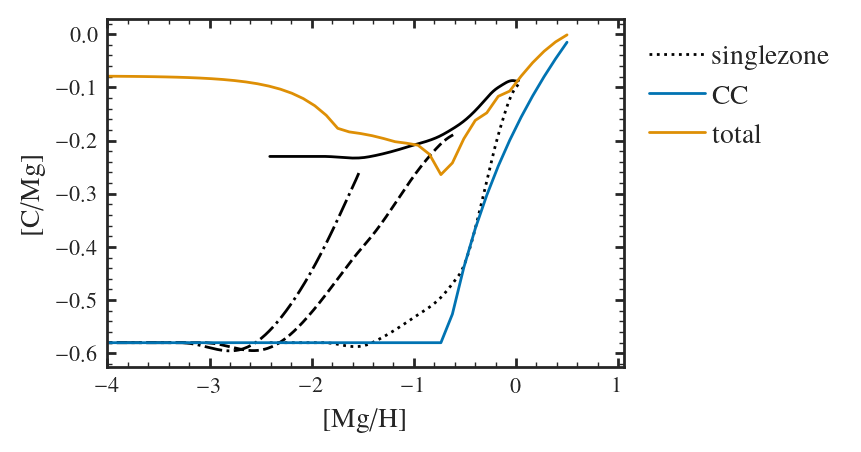

In [75]:
plot_sz(zorder=0)


plt.plot(MoverH, gcem.abund_ratio_to_brak(y_cc/yo, "c", "o"), lw=1, label="CC")
plt.plot(MoverH, gcem.abund_ratio_to_brak(y_total/yo, "c", "o"), lw=1, label="total")


plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")
plt.xlim(-4)
arya.Legend(-1)

# La Finale

In [76]:
def lower_legend_label(fig):
    plt.ylabel(r"[C/O]")

    lab = plt.xlabel(r"[O/H]")
    
    leg = fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=4, markerscale=2)
    box1 = leg.get_tightbbox()
    box2 = lab.get_tightbbox() 

    t1 = box1.transformed(fig.transFigure.inverted())
    t2 = box2.transformed(fig.transFigure.inverted())
    ym = (t2.y0 + t1.y1)/2


    fig.add_artist(mpl.lines.Line2D([t1.x0, t1.x1], [ym, ym], color="k", lw=0.5))


In [77]:
def plot_all_data():
    plot_sample_err(all_stars, all_star_err, marker="*", color=COLORS[8], label="MW stars")
    plot_sample_err(RL, marker="o", color=COLORS[1], label="MW/M101 HII Regions")
    plot_sample_err(dwarfs, dwarf_err, marker="d", color=COLORS[2], label="dwarf galaxies")
    plot_sample_err(high_z, high_z_err, marker="s", color=COLORS[6], label=r"high-$z$ galaxies")
    
    
    plot_sample_err(DLA, DLA_err, marker="^", color=COLORS[3], label=r"damped Lyman$\alpha$ systems")


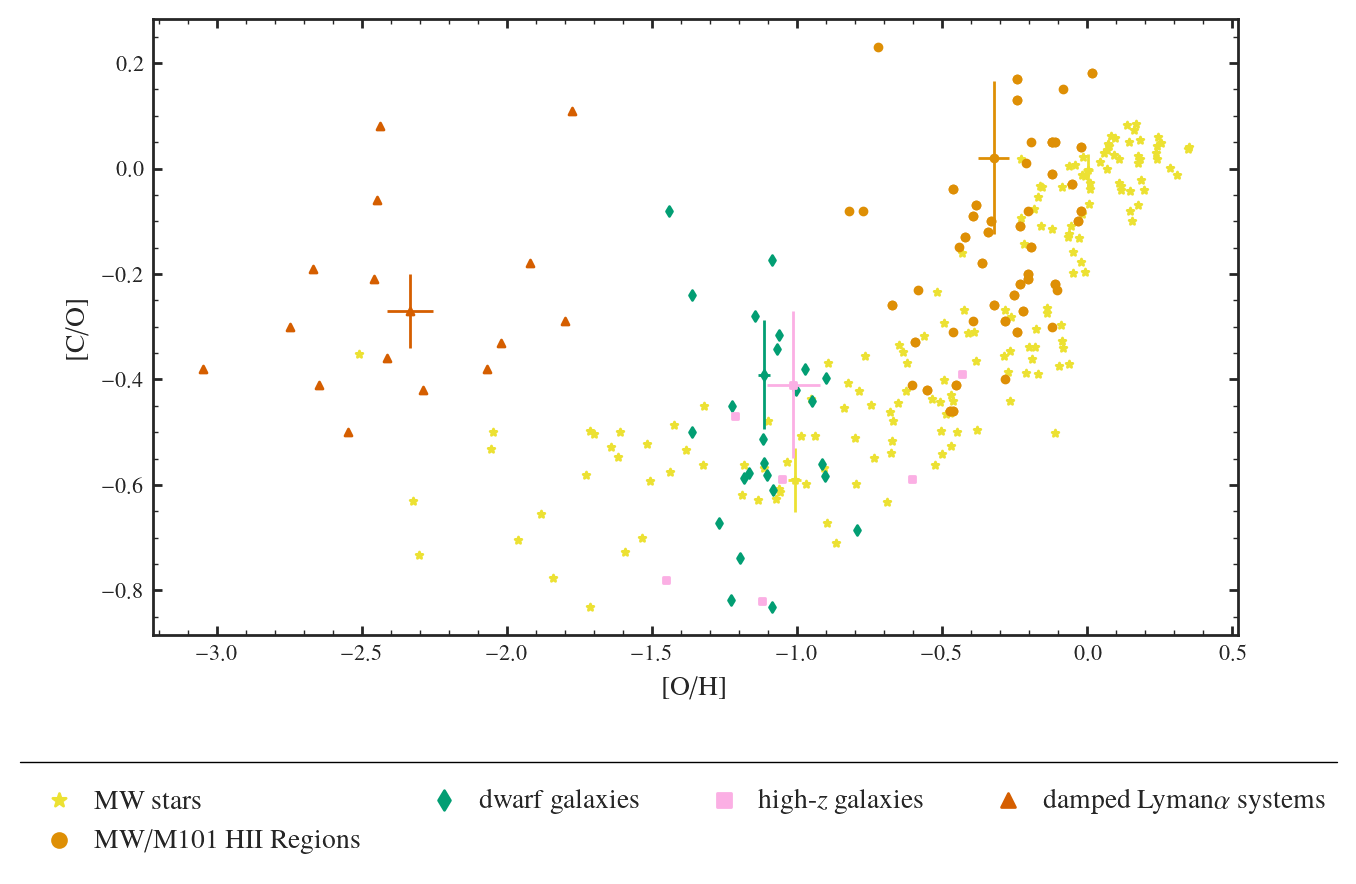

In [78]:
fig = plt.figure(figsize=(7, 4))
plot_all_data()

lower_legend_label(fig)


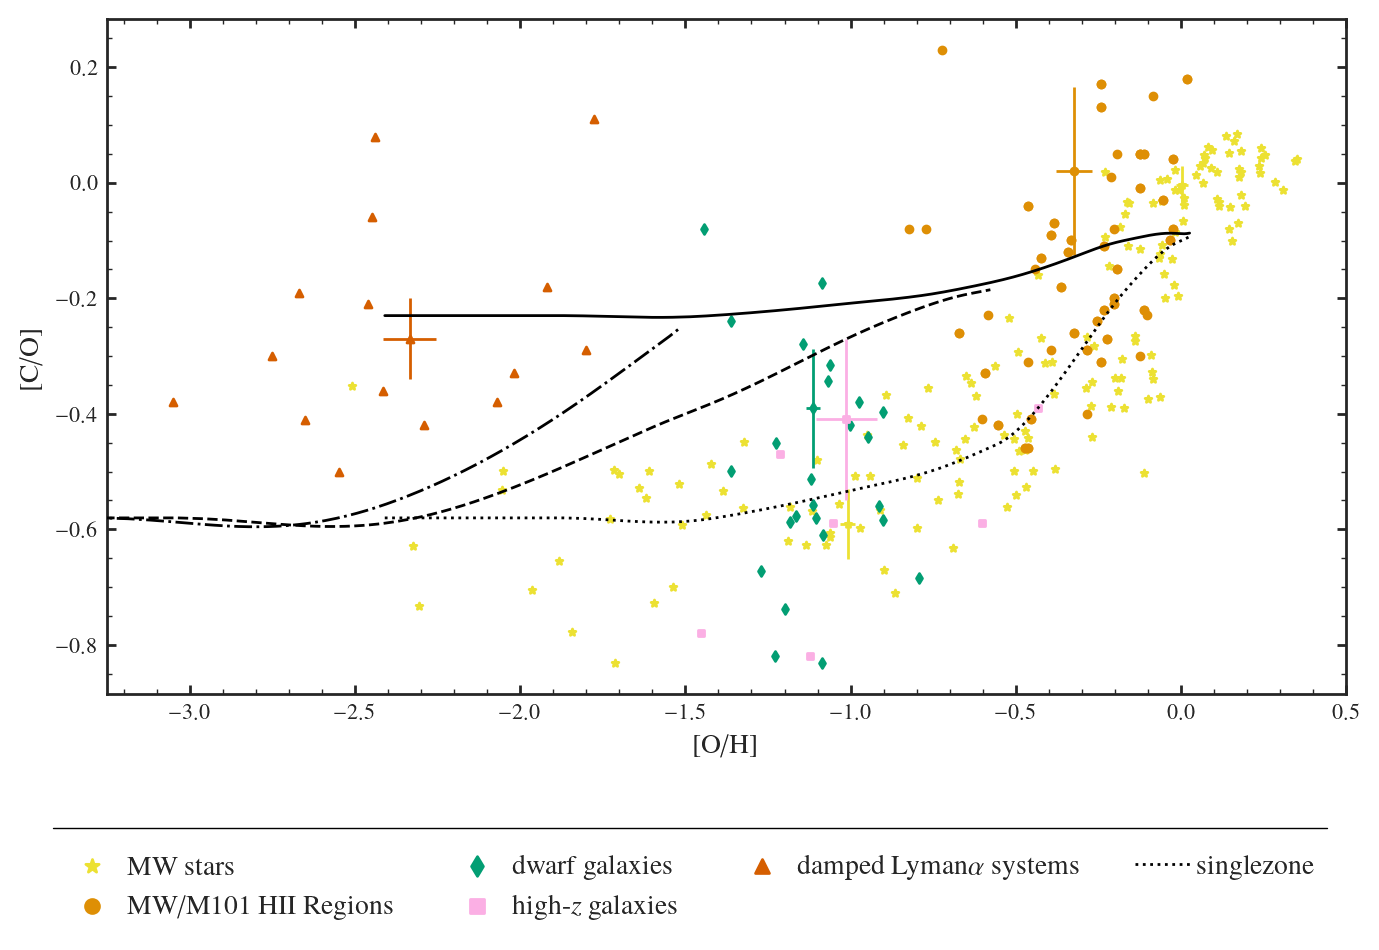

In [79]:
fig = plt.figure(figsize=(7, 4))

plot_all_data()
plot_fiducial()
plot_sz()

lower_legend_label(fig)
plt.xlim(-3.25, 0.5)
plt.tight_layout()


plt.savefig("figures/summary.pdf")